In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import Normalizer

from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import re
import string
import moralstrength #pls install using pip install moralstrength
import networkx as nx


In [70]:
import nltk
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.cluster.util import cosine_distance

nltk_stopwords = set(stopwords.words('english'))
nltk_stopwords.discard('not')  

import spacy
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])

from tqdm import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/huikhangkiat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

In [24]:
df_train = pd.read_csv("../data/df_train.csv")
df_test = pd.read_csv("../data/df_test.csv")

#indices for 10-fold cross-validation based on training data
splits_df = pd.read_csv("../data/cv_splits.csv")


Number of training samples: 2852
original_index       0
content              0
label             1426
dtype: int64
original_index       0
content              0
label             1426
dtype: int64
   original_index                                            content  label
0            1804  I've been dating (G) for 5 years, and was cons...      1
1            6394  Me (36F) and my Bestie (24F) (let’s call her T...      0
2            3406  My boyfriend of 5 years (m26) and I (f25) got ...      0
3            4471  I was told to come here. My son was married to...      0
4            2000  I (45F) only use Reddit for the cats so bear w...      1


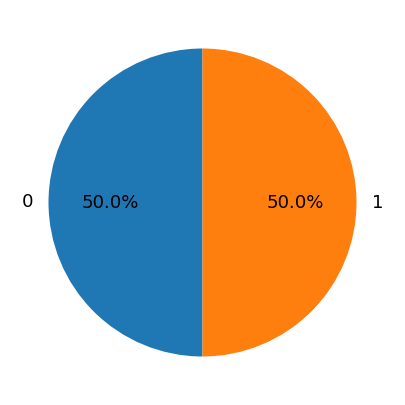

In [28]:
print("Number of training samples: {}".format(len(df_train)))
kwargs = dict(
    startangle = 90,
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    label      = ''
)

df_train['label'].value_counts().plot.pie(**kwargs)

#Undersampling majority class to balance dataset
majority_df = df_train[df_train['label'] == 0]
minority_df = df_train[df_train['label'] == 1] 
downsampled_majority_df = resample(majority_df, replace=False, n_samples=1426)
df_train = pd.concat([downsampled_majority_df, minority_df], ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)


print(df_train[df_train == 1].count())
print(df_train[df_train == 0].count())
print(df_train.head())

Number of test samples: 2385


<Axes: >

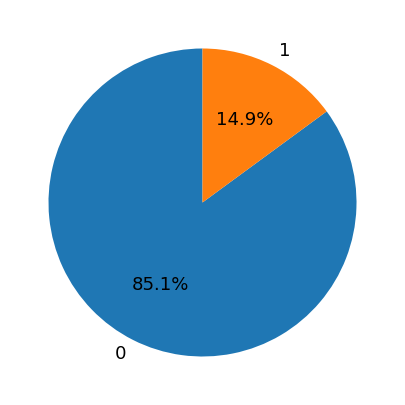

In [5]:
print("Number of test samples: {}".format(len(df_test)))
df_test['label'].value_counts().plot.pie(**kwargs)


## Text Preprocessing

In [29]:
#handling clitics
def pre_normalize_sentence(text):
    contractions = {
        # r'[\(\[].*?[\)\]]': ' ',  # Remove all words in brackets
        r"(n\'t)": " not",  # Resolve contraction "-n't"
        r"(\'ve)": " have",  # Resolve contraction "-'ve"
        r"(\'ll)": " will",  # Resolve contraction "-'ll"
        r"(\'s)": " is",  # Resolve contraction "-'s"
        r"(\'m)": " am",  # Resolve contraction "-'m"
        r"(\'d)": " would",  # Resolve contraction "-'d"
        r"(\'re)": " are",  # Resolve contraction "-'re"
    }
    for pattern, replacement in contractions.items():
        text = re.sub(pattern, replacement, text)
    return text

In [30]:
def normalized_token_list(token_list):
    for j, token in enumerate(token_list):
        text = token
        text = text.lower()                                                           # case folding
        text = re.sub(r'\s+', ' ', text)                                              # remove duplicate white space
        text = re.sub(r'([.]){2,}', ' ', text)  # Correctly remove ellipses
        text = re.sub(r'([\w.-]+)([,;])([\w.-]+)', '\g<1>\g<2> \g<3>', text)          # Add missing whitespace after , and ;
        text = re.sub(r'\s+', ' ', text)                                              # remove duplicate white space again
        text = text.strip()
        token_list[j] = text                                                          # Remove trailing whitespaces
    return token_list

In [31]:
#stopword and punctuation removal
extended_punctuation = string.punctuation + '‘’“”'

def remove_stopwords_punctuation(token_list):
    return [token for token in token_list if token not in nltk_stopwords and not all(char in extended_punctuation for char in token)]
    # return [token for token in token_list if token not in nltk_stopwords and token not in string.punctuation]

In [32]:
#Stemming
porter_stemmer = PorterStemmer()
def stem_tokens(token_list, stemmer=porter_stemmer):
    return [stemmer.stem(token) for token in token_list]

In [33]:
#POS tagging
def pos_tagging(token_list):
    return pos_tag(token_list)

In [34]:
#lemmatisation
wordnet_lemmatizer = WordNetLemmatizer()
def lemma_tokens(pos_tag_list):
    lemma_list = []
    for token, tag in pos_tag_list:
        word_type = 'n' # Default if all fails
        tag_simple = tag[0].lower() # Converts, e.g., "VBD" to "v"
        if tag_simple in ['n', 'v', 'r']:
            # If the POS tag starts with "n","v", or "r", we know it's a noun, verb, or adverb
            word_type = tag_simple 
        elif tag_simple in ['j']:
            # If the POS tag starts with a "j", we know it's an adjective
            word_type = 'a' 
        lemma_list.append(wordnet_lemmatizer.lemmatize(token.lower(), pos=word_type))
    return lemma_list

In [173]:
#splitting each post into sentences
def read_post(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    # # Tokenize and remove stopwords
    # if stopwords is None:
    #     stopwords = []
    # sent1 = [word.lower() for word in word_tokenize(sent1) if word.lower() not in stopwords]
    # sent2 = [word.lower() for word in word_tokenize(sent2) if word.lower() not in stopwords]

    # Create a set of all unique words in both sentences
    all_words = list(set(sent1 + sent2))

    # Create vectors to represent each sentence
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)

    # Count word occurrences
    for word in sent1:
        vector1[all_words.index(word)] += 1

    for word in sent2:
        vector2[all_words.index(word)] += 1

    # Calculate cosine similarity
    return 1 - cosine_distance(vector1, vector2)

def build_similarity_matrix(sentences, stopwords):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))

    # Fill the similarity matrix with cosine similarity scores
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2:
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stopwords)

    return similarity_matrix

def generate_summary(text, top_n=5):
    # Load English stopwords
    stop_words = stopwords.words('english')

    # Tokenize the text into sentences
    sentences = read_post(text)

    # Generate the sentence similarity matrix
    sentence_similarity_matrix = build_similarity_matrix(sentences, stop_words)

    # Convert the similarity matrix into a graph
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)

    # Apply the PageRank algorithm to rank the sentences
    scores = nx.pagerank(sentence_similarity_graph, max_iter=200)

    # Sort the sentences by their scores
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    # Extract the top sentences as the summary
    summary = [sentence for score, sentence in ranked_sentences[:top_n]]

    while len(summary) < top_n:
      summary.append('')

    return summary

def split_into_sentences(post_df):
    sent1 = []
    sent2 = []
    sent3 = []
    sent4 = []
    sent5 = []
    index = 0
        
    for i, content in enumerate(post_df['content']):
        array_summary = generate_summary(content)
        sent1.append(array_summary[0])
        sent2.append(array_summary[1])
        sent3.append(array_summary[2])
        sent4.append(array_summary[3])
        sent5.append(array_summary[4])
        index = i
    
    post_df['sent1'] = sent1
    post_df['sent2'] = sent2
    post_df['sent3'] = sent3
    post_df['sent4'] = sent4
    post_df['sent5'] = sent5

    # To rearrange the order of sentences as specified (1.1, 1.2, ..., 1.5, then 2.1, ..., 2.5, etc.),
    # we can first transpose the DataFrame and then use the same approach to melt it into a single column.
    
    # Transposing the original DataFrame so that each sentence sequence becomes a row
    post_df_transposed = post_df[['sent1', 'sent2', 'sent3', 'sent4', 'sent5']].T
    
    # Resetting the index since after transposition, the original column names become the index
    post_df_transposed.reset_index(drop=True, inplace=True)
    
    # Melting the transposed DataFrame without considering variable names, just values
    df_long_transposed = pd.melt(post_df_transposed, value_name="content")["content"]
    
    # Converting the Series into a DataFrame
    df_ordered = df_long_transposed.to_frame().reset_index(drop=True)
    
    return df_ordered

In [174]:
# Combined preprocessing pipeline
# pipeline with nltk + lemmatization
def preprocess_pipeline_lemma(sentences):
    preprocessed_data = []
    
    for idx, sentence in enumerate(sentences):
        normalized_sentence = pre_normalize_sentence(sentence)
        tweet_tokenizer = TweetTokenizer()
        tokens = tweet_tokenizer.tokenize(normalized_sentence)
        tokens = normalized_token_list(tokens)
        tokens = remove_stopwords_punctuation(tokens)
        tokens = pos_tagging(tokens)
        tokens = lemma_tokens(tokens)
        #removing empty records after preprocessing
        # if len(tokens) == 0:
        #     print(sentences.iloc[idx])
        #     continue
        preprocessed_data.append(tokens)
        # if len(labels) > 0:
        #     preprocessed_labels.append(labels.iloc[idx])
    return preprocessed_data

# pipeline with nltk + stemming
def preprocess_pipeline_stem(sentences, stemmer=porter_stemmer):
    preprocessed_data = []
    # preprocessed_labels = []
    for idx, sentence in enumerate(sentences):
        normalized_sentence = pre_normalize_sentence(sentence)
        tweet_tokenizer = TweetTokenizer()
        tokens = tweet_tokenizer.tokenize(normalized_sentence)
        tokens = normalized_token_list(tokens)
        tokens = remove_stopwords_punctuation(tokens)
        tokens = stem_tokens(tokens, stemmer)
        #removing empty records after preprocessing
        # if len(tokens) == 0:
        #     print(sentences.iloc[idx])
        #     continue
        preprocessed_data.append(tokens)
        # if len(labels) > 0:
        #     preprocessed_labels.append(labels.iloc[idx])
    return preprocessed_data

#pipeline using spaCy with lemmatization, stopword and punctuation removal
def preprocess_spacy(posts, moral='No'):
    preprocessed_data = []
    
    # Assuming 'sentences' is a pandas Series or similar iterable of strings
    for post in posts:
        # print(post)
        normalized_post = pre_normalize_sentence(post)
        cleaned_post = normalized_post.replace('\n\n', '').replace('\n', '')
        doc = nlp(cleaned_post)
        if moral == 'No':
            preprocessed_tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
        else:
            preprocessed_tokens = [token for token in doc if not token.is_stop and not token.is_punct]
        preprocessed_data.append(preprocessed_tokens)

    return preprocessed_data

#pipeline using spaCy with lemmatization, stopword and punctuation removal
def preprocess_spacy_moral_sentences(posts, moral='No'):
    posts = posts.to_frame(name='content')
    posts = split_into_sentences(posts)
    preprocessed_data = []
    
    # Assuming 'sentences' is a pandas Series or similar iterable of strings
    for post in posts['content']:
        normalized_post = pre_normalize_sentence(post)
        cleaned_post = normalized_post.replace('\n\n', '').replace('\n', '')
        doc = nlp(cleaned_post)
        if moral == 'No':
            preprocessed_tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
        else:
            preprocessed_tokens = [token for token in doc if not token.is_stop and not token.is_punct]
        preprocessed_data.append(preprocessed_tokens)
    return preprocessed_data

In [40]:
preprocessed_spacy_train = preprocess_spacy(df_train['content'], morals='Yes')
result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed


print(result)

          care  fairness   loyalty authority    purity
0          1.6       NaN       NaN  7.777778       NaN
1      5.02381       8.0  7.781746  5.285714       8.0
2     8.166667       NaN       8.0    7.4375       NaN
3     2.285714       NaN  4.785714      6.58       8.0
4          NaN  7.683333       6.5     7.325  2.666667
...        ...       ...       ...       ...       ...
2847       NaN       NaN  8.291667  7.389881      2.75
2848       NaN       NaN       NaN  3.857143       3.0
2849       NaN  6.940476  7.541667  6.888889       NaN
2850       NaN       NaN       8.0  6.791667  2.714286
2851       4.7  5.588889       7.5  7.480072  7.095238

[2852 rows x 5 columns]


In [76]:
result['moral_score'] = result.mean(axis=1)
print(result.head())
print((result['moral_score'].isnull.sum())
print(len(result))


<class 'pandas.core.frame.DataFrame'>
       care  fairness   loyalty  authority    purity  moral_score
0  2.285714       NaN  4.785714   6.580000  8.000000     4.438543
1       NaN  7.683333  6.500000   7.325000  2.666667     4.955875
2       NaN  7.000000  8.000000   7.294444  6.000000     5.800361
3  4.630952  7.200000  7.928571   3.857143  6.428571     5.107690
4       NaN  8.166667  8.000000        NaN  7.666667     6.156944
0
1426


## Classificaiton Models

### Naive Bayes Classifier (processing whole text, and text split into sentences)

##### Including additional handcrafted feature of moral_score from morality lexicon

In [175]:
X_nb = df_train['content'].copy()
y_nb = df_train['label'].copy()

# Initialize the StratifiedKFold class
n_splits = 2  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define preprocessing and vectorization configurations
preprocessing_type = {
    # 'lemmatization_tfidf': (preprocess_pipeline_lemma, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True)),
    # 'stemming_tfidf': (preprocess_pipeline_stem, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'vanilla_tfidf': (None, TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)),
    'spacy_tfidf': (preprocess_spacy, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'lemmatization_bow': (preprocess_pipeline_lemma, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    # 'stemming_bow': (preprocess_pipeline_stem, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    # 'vanilla_bow': (None, CountVectorizer(ngram_range=(1,1))),
    # 'spacy_bow': (preprocess_spacy, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    'spacy_sentences': (preprocess_spacy_moral_sentences, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,))

}

for preprocessor, (preprocess_pipeline, vectorizer) in preprocessing_type.items():
    val_f1s = []
    print(preprocessor)
    for train_index, test_index in skf.split(X_nb, y_nb):
        X_train_nb, X_val_nb = X_nb[train_index], X_nb[test_index]
        y_train_nb, y_val_nb = y_nb[train_index], y_nb[test_index]
        
        # Apply preprocessing if specified
        if preprocess_pipeline:
            X_train_nb_preprocessed = preprocess_pipeline(X_train_nb)
            X_val_nb_preprocessed = preprocess_pipeline(X_val_nb)
            # print(X_train_nb_preprocessed[0:10])
        # Vectorize data
        X_train_nb_vec = vectorizer.fit_transform(X_train_nb_preprocessed)
        X_val_nb_vec = vectorizer.transform(X_val_nb_preprocessed)
        # print(y_train_nb.shape)
        # print(y_train_nb[0:10])

        if preprocess_pipeline == preprocess_spacy_moral_sentences:
            y_train_nb = np.repeat(y_train_nb, 5)
            y_val_nb = np.repeat(y_val_nb, 5)
            # print(y_train_nb.shape)
            # print(y_train_nb[0:10])
        
        
        # # Add morality score and append it to X_train_nb_vec and X_test_nb_vec
        # X_train_nb = X_train_nb.to_frame()
        # X_test_nb = X_test_nb.to_frame()

        # print(type(X_train_nb_vec))
        preprocessed_spacy_train = preprocess_pipeline(X_train_nb, moral='Yes')
        result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
        result['moral_score'] = result.mean(axis=1)/10 #normalize score to 0 to 1
        result['moral_score'] = result['moral_score'].fillna(-1)
        result_moral_matrix = csr_matrix((result['moral_score']).values.reshape(-1, 1)) # Reshape if necessary
        X_train_nb_vec = hstack([X_train_nb_vec, result_moral_matrix])

        # print(X_train_nb_vec.shape)
        # print(X_train_nb_vec[0:10])
        
        preprocessed_spacy_val = preprocess_pipeline(X_val_nb, moral='Yes')
        result_val = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
        #normalizing moral score (scale of 0-10, normalized to 0-1)
        result_val['moral_score'] = result_val.mean(axis=1)/10 #normalize score to 0 to 1
        result_val['moral_score'] = result_val['moral_score'].fillna(-1) #assign moral score of -1 to null values
        result_moral_matrix_val = csr_matrix((result_val['moral_score']).values.reshape(-1, 1))
        X_val_nb_vec = hstack([X_val_nb_vec, result_moral_matrix_val])

        # # Dropping rows with null value for moral score
        keep_indices_train = result[result['moral_score'] != -1].index
        keep_indices_val = result_val[result_val['moral_score'] != -1].index
        # Filter the stacked matrices to keep only the desired rows
        X_train_nb_vec = X_train_nb_vec[keep_indices_train, :]
        X_val_nb_vec = X_val_nb_vec[keep_indices_val, :]
        y_train_nb = y_train_nb.iloc[keep_indices_train]
        y_val_nb = y_val_nb.iloc[keep_indices_val]

        # print(X_train_nb_vec.shape)
        # print(X_train_nb_vec[0:10])
        # print(y_train_nb.shape)
        # print(y_train_nb[0:10])
        # # Normalize the training and validation vectors
        # normalizer = Normalizer()
        # X_train_nb_vec_normalized = normalizer.fit_transform(X_train_nb_vec)
        # X_val_nb_vec_normalized = normalizer.transform(X_val_nb_vec)

        # print(X_train_nb_vec_normalized[0])

        # Initialize the Bernoulli Naive Bayes model
        model = BernoulliNB()
    
        # Fit the model
        model.fit(X_train_nb_vec, y_train_nb)
    
        # Predict on the test set
        y_pred_nb = model.predict(X_val_nb_vec)
        
        val_f1s.append(f1_score(y_val_nb, y_pred_nb))

    # Calculate and print the average F1 score across all validation folds
    print(f"Results for {preprocessor}:")
    print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

spacy_tfidf


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/947342541.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_val['moral_score'] = result_val['moral_score'].fillna(-1) #assign moral score of -1 to null values
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/947342541.py:55: FutureWarning: Downcasting object dtype arrays on 

Results for spacy_tfidf:
Average Cross-Validation F1 Score: 0.610

spacy_sentences


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/947342541.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result['moral_score'] = result['moral_score'].fillna(-1)
/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/947342541.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_val['moral_score'] = result_val['

Results for spacy_sentences:
Average Cross-Validation F1 Score: 0.536



/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/947342541.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_val['moral_score'] = result_val['moral_score'].fillna(-1) #assign moral score of -1 to null values


##### No additional handcrafted features

In [178]:
X_nb = df_train['content'].copy()
y_nb = df_train['label'].copy()

# Initialize the StratifiedKFold class
n_splits = 2  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define preprocessing and vectorization configurations
preprocessing_type = {
    # 'lemmatization_tfidf': (preprocess_pipeline_lemma, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True)),
    # 'stemming_tfidf': (preprocess_pipeline_stem, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'vanilla_tfidf': (None, TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)),
    'spacy_tfidf': (preprocess_spacy, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'lemmatization_bow': (preprocess_pipeline_lemma, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    # 'stemming_bow': (preprocess_pipeline_stem, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    # 'vanilla_bow': (None, CountVectorizer(ngram_range=(1,1))),
    # 'spacy_bow': (preprocess_spacy, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    'spacy_sentences': (preprocess_spacy_moral_sentences, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,))

}

for preprocessor, (preprocess_pipeline, vectorizer) in preprocessing_type.items():
    val_f1s = []
    print(preprocessor)
    for train_index, test_index in skf.split(X_nb, y_nb):
        X_train_nb, X_val_nb = X_nb[train_index], X_nb[test_index]
        y_train_nb, y_val_nb = y_nb[train_index], y_nb[test_index]
        
        # Apply preprocessing if specified
        if preprocess_pipeline:
            X_train_nb_preprocessed = preprocess_pipeline(X_train_nb)
            X_val_nb_preprocessed = preprocess_pipeline(X_val_nb)
            # print(X_train_nb_preprocessed[0:10])
        # Vectorize data
        X_train_nb_vec = vectorizer.fit_transform(X_train_nb_preprocessed)
        X_val_nb_vec = vectorizer.transform(X_val_nb_preprocessed)
        # print(y_train_nb.shape)
        # print(y_train_nb[0:10])

        if preprocess_pipeline == preprocess_spacy_moral_sentences:
            y_train_nb = np.repeat(y_train_nb, 5)
            y_val_nb = np.repeat(y_val_nb, 5)
            # print(y_train_nb.shape)
            # print(y_train_nb[0:10])
        
        
        # # Add morality score and append it to X_train_nb_vec and X_test_nb_vec
        # X_train_nb = X_train_nb.to_frame()
        # X_test_nb = X_test_nb.to_frame()

        # # print(type(X_train_nb_vec))
        # preprocessed_spacy_train = preprocess_pipeline(X_train_nb, moral='Yes')
        # result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
        # result['moral_score'] = result.mean(axis=1)/10 #normalize score to 0 to 1
        # result['moral_score'] = result['moral_score'].fillna(-1)
        # result_moral_matrix = csr_matrix((result['moral_score']).values.reshape(-1, 1)) # Reshape if necessary
        # X_train_nb_vec = hstack([X_train_nb_vec, result_moral_matrix])

        # print(X_train_nb_vec.shape)
        # print(X_train_nb_vec[0:10])
        
        # preprocessed_spacy_val = preprocess_pipeline(X_val_nb, moral='Yes')
        # result_val = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
        # #normalizing moral score (scale of 0-10, normalized to 0-1)
        # result_val['moral_score'] = result_val.mean(axis=1)/10 #normalize score to 0 to 1
        # result_val['moral_score'] = result_val['moral_score'].fillna(-1) #assign moral score of -1 to null values
        # result_moral_matrix_val = csr_matrix((result_val['moral_score']).values.reshape(-1, 1))
        # X_val_nb_vec = hstack([X_val_nb_vec, result_moral_matrix_val])

        # # # Dropping rows with null value for moral score
        # keep_indices_train = result[result['moral_score'] != -1].index
        # keep_indices_val = result_val[result_val['moral_score'] != -1].index
        # # Filter the stacked matrices to keep only the desired rows
        # X_train_nb_vec = X_train_nb_vec[keep_indices_train, :]
        # X_val_nb_vec = X_val_nb_vec[keep_indices_val, :]
        # y_train_nb = y_train_nb.iloc[keep_indices_train]
        # y_val_nb = y_val_nb.iloc[keep_indices_val]

        # print(X_train_nb_vec.shape)
        # print(X_train_nb_vec[0:10])
        # print(y_train_nb.shape)
        # print(y_train_nb[0:10])
        # # # Normalize the training and validation vectors
        # # normalizer = Normalizer()
        # # X_train_nb_vec_normalized = normalizer.fit_transform(X_train_nb_vec)
        # # X_val_nb_vec_normalized = normalizer.transform(X_val_nb_vec)

        # # print(X_train_nb_vec_normalized[0])

        # Initialize the Bernoulli Naive Bayes model
        model = BernoulliNB()
    
        # Fit the model
        model.fit(X_train_nb_vec, y_train_nb)
    
        # Predict on the test set
        y_pred_nb = model.predict(X_val_nb_vec)
        
        val_f1s.append(f1_score(y_val_nb, y_pred_nb))

    # Calculate and print the average F1 score across all validation folds
    print(f"Results for {preprocessor}:")
    print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

spacy_tfidf


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for spacy_tfidf:
Average Cross-Validation F1 Score: 0.612

spacy_sentences


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for spacy_sentences:
Average Cross-Validation F1 Score: 0.533



/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Logistic Regression

##### With additional handcrafted feature

In [179]:
X_lr = df_train['content'].copy()
y_lr = df_train['label'].copy()

# Initialize the StratifiedKFold class
n_splits = 2  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define preprocessing and vectorization configurations
preprocessing_type = {
    # 'lemmatization_tfidf': (preprocess_pipeline_lemma, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True)),
    # 'stemming_tfidf': (preprocess_pipeline_stem, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'vanilla_tfidf': (None, TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)),
    'spacy_tfidf': (preprocess_spacy, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'lemmatization_bow': (preprocess_pipeline_lemma, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    # 'stemming_bow': (preprocess_pipeline_stem, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    # 'vanilla_bow': (None, CountVectorizer(ngram_range=(1,1))),
    # 'spacy_bow': (preprocess_spacy, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    'spacy_sentences': (preprocess_spacy_moral_sentences, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,))

}

for preprocessor, (preprocess_pipeline, vectorizer) in preprocessing_type.items():
    val_f1s = []
    print(preprocessor)
    for train_index, test_index in skf.split(X_nb, y_nb):
        X_train_nb, X_val_nb = X_nb[train_index], X_nb[test_index]
        y_train_nb, y_val_nb = y_nb[train_index], y_nb[test_index]
        
        # Apply preprocessing if specified
        if preprocess_pipeline:
            X_train_nb_preprocessed = preprocess_pipeline(X_train_nb)
            X_val_nb_preprocessed = preprocess_pipeline(X_val_nb)
        # Vectorize data
        X_train_nb_vec = vectorizer.fit_transform(X_train_nb_preprocessed)
        X_val_nb_vec = vectorizer.transform(X_val_nb_preprocessed)
        # print(y_train_nb.shape)
        # print(y_train_nb[0:10])

        if preprocess_pipeline == preprocess_spacy_moral_sentences:
            y_train_nb = np.repeat(y_train_nb, 5)
            y_val_nb = np.repeat(y_val_nb, 5)
            # print(y_train_nb.shape)
            # print(y_train_nb[0:10])
        
        
        # # Add morality score and append it to X_train_nb_vec and X_test_nb_vec
        # X_train_nb = X_train_nb.to_frame()
        # X_test_nb = X_test_nb.to_frame()

        # print(type(X_train_nb_vec))
        preprocessed_spacy_train = preprocess_pipeline(X_train_nb, moral='Yes')
        result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
        result['moral_score'] = result.mean(axis=1)/10 #normalize score to 0 to 1
        result['moral_score'] = result['moral_score'].fillna(-1)
        result_moral_matrix = csr_matrix((result['moral_score']).values.reshape(-1, 1)) # Reshape if necessary
        X_train_nb_vec = hstack([X_train_nb_vec, result_moral_matrix])
        
        preprocessed_spacy_val = preprocess_pipeline(X_val_nb, moral='Yes')
        result_val = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
        #normalizing moral score (scale of 0-10, normalized to 0-1)
        result_val['moral_score'] = result_val.mean(axis=1)/10 #normalize score to 0 to 1
        result_val['moral_score'] = result_val['moral_score'].fillna(-1) #assign moral score of -1 to null values
        result_moral_matrix_val = csr_matrix((result_val['moral_score']).values.reshape(-1, 1))
        X_val_nb_vec = hstack([X_val_nb_vec, result_moral_matrix_val])

        # # Dropping rows with null value for moral score
        keep_indices_train = result[result['moral_score'] != -1].index
        keep_indices_val = result_val[result_val['moral_score'] != -1].index
        # Filter the stacked matrices to keep only the desired rows
        X_train_nb_vec = X_train_nb_vec[keep_indices_train, :]
        X_val_nb_vec = X_val_nb_vec[keep_indices_val, :]
        y_train_nb = y_train_nb.iloc[keep_indices_train]
        y_val_nb = y_val_nb.iloc[keep_indices_val]

        # print(X_train_nb_vec.shape)
        # print(X_train_nb_vec[0:10])
        # print(y_train_nb.shape)
        # print(y_train_nb[0:10])
        # # Normalize the training and validation vectors
        # normalizer = Normalizer()
        # X_train_nb_vec_normalized = normalizer.fit_transform(X_train_nb_vec)
        # X_val_nb_vec_normalized = normalizer.transform(X_val_nb_vec)

        # print(X_train_nb_vec_normalized[0])

        # Initialize the Bernoulli Naive Bayes model
        model = LogisticRegression()
    
        # Fit the model
        model.fit(X_train_nb_vec, y_train_nb)
    
        # Predict on the test set
        y_pred_nb = model.predict(X_val_nb_vec)
        
        val_f1s.append(f1_score(y_val_nb, y_pred_nb))

    # Calculate and print the average F1 score across all validation folds
    print(f"Results for {preprocessor}:")
    print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

spacy_tfidf


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/428183430.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_val['moral_score'] = result_val['moral_score'].fillna(-1) #assign moral score of -1 to null values
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/428183430.py:54: FutureWarning: Downcasting object dtype arrays on 

Results for spacy_tfidf:
Average Cross-Validation F1 Score: 0.581

spacy_sentences


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/428183430.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result['moral_score'] = result['moral_score'].fillna(-1)
/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/428183430.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_val['moral_score'] = result_val['

Results for spacy_sentences:
Average Cross-Validation F1 Score: 0.530



/var/folders/4v/x8qlyms56rsb_h37mylbhlz80000gn/T/ipykernel_81934/428183430.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_val['moral_score'] = result_val['moral_score'].fillna(-1) #assign moral score of -1 to null values


##### Without additional handcrafted feature

In [180]:
X_lr = df_train['content'].copy()
y_lr = df_train['label'].copy()

# Initialize the StratifiedKFold class
n_splits = 2  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define preprocessing and vectorization configurations
preprocessing_type = {
    # 'lemmatization_tfidf': (preprocess_pipeline_lemma, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True)),
    # 'stemming_tfidf': (preprocess_pipeline_stem, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'vanilla_tfidf': (None, TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)),
    'spacy_tfidf': (preprocess_spacy, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'lemmatization_bow': (preprocess_pipeline_lemma, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    # 'stemming_bow': (preprocess_pipeline_stem, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    # 'vanilla_bow': (None, CountVectorizer(ngram_range=(1,1))),
    # 'spacy_bow': (preprocess_spacy, CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x: x)),
    'spacy_sentences': (preprocess_spacy_moral_sentences, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,))

}

for preprocessor, (preprocess_pipeline, vectorizer) in preprocessing_type.items():
    val_f1s = []
    print(preprocessor)
    for train_index, test_index in skf.split(X_nb, y_nb):
        X_train_nb, X_val_nb = X_nb[train_index], X_nb[test_index]
        y_train_nb, y_val_nb = y_nb[train_index], y_nb[test_index]
        
        # Apply preprocessing if specified
        if preprocess_pipeline:
            X_train_nb_preprocessed = preprocess_pipeline(X_train_nb)
            X_val_nb_preprocessed = preprocess_pipeline(X_val_nb)
        # Vectorize data
        X_train_nb_vec = vectorizer.fit_transform(X_train_nb_preprocessed)
        X_val_nb_vec = vectorizer.transform(X_val_nb_preprocessed)
        # print(y_train_nb.shape)
        # print(y_train_nb[0:10])

        if preprocess_pipeline == preprocess_spacy_moral_sentences:
            y_train_nb = np.repeat(y_train_nb, 5)
            y_val_nb = np.repeat(y_val_nb, 5)
            # print(y_train_nb.shape)
            # print(y_train_nb[0:10])
        
        
        # # Add morality score and append it to X_train_nb_vec and X_test_nb_vec
        # X_train_nb = X_train_nb.to_frame()
        # X_test_nb = X_test_nb.to_frame()

        # # print(type(X_train_nb_vec))
        # preprocessed_spacy_train = preprocess_pipeline(X_train_nb, moral='Yes')
        # result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
        # result['moral_score'] = result.mean(axis=1)/10 #normalize score to 0 to 1
        # result['moral_score'] = result['moral_score'].fillna(-1)
        # result_moral_matrix = csr_matrix((result['moral_score']).values.reshape(-1, 1)) # Reshape if necessary
        # X_train_nb_vec = hstack([X_train_nb_vec, result_moral_matrix])

        # print(X_train_nb_vec.shape)
        # print(X_train_nb_vec[0:10])
        
        # preprocessed_spacy_val = preprocess_pipeline(X_val_nb, moral='Yes')
        # result_val = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
        # #normalizing moral score (scale of 0-10, normalized to 0-1)
        # result_val['moral_score'] = result_val.mean(axis=1)/10 #normalize score to 0 to 1
        # result_val['moral_score'] = result_val['moral_score'].fillna(-1) #assign moral score of -1 to null values
        # result_moral_matrix_val = csr_matrix((result_val['moral_score']).values.reshape(-1, 1))
        # X_val_nb_vec = hstack([X_val_nb_vec, result_moral_matrix_val])

        # # # Dropping rows with null value for moral score
        # keep_indices_train = result[result['moral_score'] != -1].index
        # keep_indices_val = result_val[result_val['moral_score'] != -1].index
        # # Filter the stacked matrices to keep only the desired rows
        # X_train_nb_vec = X_train_nb_vec[keep_indices_train, :]
        # X_val_nb_vec = X_val_nb_vec[keep_indices_val, :]
        # y_train_nb = y_train_nb.iloc[keep_indices_train]
        # y_val_nb = y_val_nb.iloc[keep_indices_val]

        # print(X_train_nb_vec.shape)
        # print(X_train_nb_vec[0:10])
        # print(y_train_nb.shape)
        # print(y_train_nb[0:10])
        # # # Normalize the training and validation vectors
        # # normalizer = Normalizer()
        # # X_train_nb_vec_normalized = normalizer.fit_transform(X_train_nb_vec)
        # # X_val_nb_vec_normalized = normalizer.transform(X_val_nb_vec)

        # # print(X_train_nb_vec_normalized[0])

        # Initialize the Bernoulli Naive Bayes model
        model = LogisticRegression()
    
        # Fit the model
        model.fit(X_train_nb_vec, y_train_nb)
    
        # Predict on the test set
        y_pred_nb = model.predict(X_val_nb_vec)
        
        val_f1s.append(f1_score(y_val_nb, y_pred_nb))

    # Calculate and print the average F1 score across all validation folds
    print(f"Results for {preprocessor}:")
    print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

spacy_tfidf


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for spacy_tfidf:
Average Cross-Validation F1 Score: 0.576

spacy_sentences


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for spacy_sentences:
Average Cross-Validation F1 Score: 0.527



/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


##### Test data

In [ ]:
X_train_LR_final = df_train['content'].copy()
y_train_LR_final = df_train['label'].copy()
X_test_LR_final = df_test['content'].copy()
y_test_LR_final = df_test['label'].copy()

#using spacy_tfidf as vectorizer 
prepocess_pipeline = preprocess_spacy
vectorizer = TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)

#preprocess
X_train_LR_final = preprocess_pipeline(X_train_LR_final)
X_test_LR_final = preprocess_pipeline(X_test_LR_final)

print(X_train_LR_final.shape)
# Vectorize data
X_train_LR_final_vec = vectorizer.fit_transform(X_train_LR_final)
X_test_LR_final_vec = vectorizer.transform(X_test_LR_final)
print(X_train_LR_final_vec.shape)

model_LR_final = LogisticRegression()
model_LR_final.fit(X_train_LR_final_vec, y_train_LR_final)

y_pred_LR_final = model_LR_final.predict(X_test_LR_final_vec)
test_f1_score_lr = f1_score(y_test_LR_final, y_pred_LR_final)

print(f"Final Test F1 Score for Logistic Regression: {test_f1_score_lr:.3f}")

